**Import dei pacchetti necessari**

In [ ]:
! pip install sklearn --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for sklearn
  Running setup.py clean for sklearn
Failed to build sklearn
  Running setup.py install for sklearn ... done
  DEPRECATION: sklearn was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [ ]:
import pandas as pd
import numpy as np

import gzip
import json
import joblib
import os
import re
import unicodedata

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from matplotlib import pyplot as plt

import warnings
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.io.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Embedding, LSTM, GRU, Conv1D, AveragePooling1D, Flatten, MaxPooling1D

import sklearn
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


import os, logging

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

import tensorflow as tf
import tensorflow_hub as hub



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 11.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


**Import**

In [ ]:
df=pd.read_excel("/content/LDA_260123.xlsx")
df2=pd.read_excel("/content/BeyondBlue_220123.xlsx")


In [ ]:
print(len(df))
print(len(df2))

14739
14739


Add columns from topic db

In [ ]:
df2['Topic']=df['Dominant_Topic'].astype(str)

Add columns from LIWC db

In [ ]:
if 'Category' in list(set(df2.columns)):
  df2.rename(columns={'Category':'category'},inplace=True)
if 'text' in list(set(df2.columns)):
  df2.rename(columns={'text':'Text'},inplace=True)  


In [ ]:
df2.category=df2.category.str.replace("Suicide", "0")
df2.category=df2.category.str.replace("depression", "1")
df2.category=df2.category.str.replace("Anxiety", "2")
df2.category=df2.category.str.replace("PTSD and Trauma", "3")

In [ ]:
df2['Label']=0
df2.loc[df2.category=='0','Label']=1


In [ ]:
df2['category'].value_counts()

2    6528
1    5590
3    1730
0     891
Name: category, dtype: int64

In [ ]:
df2=df2.rename(columns={0:'Text'})

In [ ]:
# Drop rows where the "Text" column is empty
df2.dropna(subset=["Text"], inplace=True)


In [ ]:
# Define a function to calculate the first person rate for a given text sample
def calculate_first_person_rate(text):
    # Convert the text to lowercase
    text = text.lower()
    # Count the occurrences of the first person pronouns
    first_person_count = text.count("i") + text.count("am") + text.count("i'm") + text.count("me") + text.count("mine")
    # Count the total number of words in the text
    total_word_count = len(text.split())

    if total_word_count == 0:
      first_person_rate = 0
    else:


       # Calculate the first person rate
      first_person_rate = first_person_count / total_word_count
      return first_person_rate

# Apply the function to the "Text" column of the DataFrame
df2['First person rate'] = df2['Text'].apply(calculate_first_person_rate)

# Display the resulting DataFrame
print(df2)

       Unnamed: 0                                               Text category  \
0               1             Safety planning involves creating a...        0   
1               2             Life gets pretty hard sometimes and...        0   
2               3             I feel like I have heaps of people ...        0   
3               4             i'm having such a hard time lately....        0   
4               5             I just need to write down how I’m f...        0   
...           ...                                                ...      ...   
14734        1899             Hi Last year my husband was diagnos...        3   
14735        1900             I was recently involved in a trauma...        3   
14736        1901             On the outside everyone thinks we a...        3   
14737        1902             Hi, I am new to this and really don...        3   
14738        1903             just want to say hello. im struggin...        3   

      Topic  Label  First p

In [ ]:
df2.head()

,Unnamed: 0,Text,category,Topic,Label,First person rate
0,1,Safety planning involves creating a...,0,1,1,0.320946
1,2,Life gets pretty hard sometimes and...,0,0,1,0.367089
2,3,I feel like I have heaps of people ...,0,2,1,0.321739
3,4,i'm having such a hard time lately....,0,2,1,0.408451
4,5,I just need to write down how I’m f...,0,2,1,0.437500


**Pre-processing**



*   Tokenization
*   Normalization
*   Lemmatization
*   Stop-words removal
*   Addictional









In [ ]:
# replace delle abbreviazioni
def replace_words(data_text):
  data_text = data_text.str.lower()
  data_text = data_text.replace('\n','', regex=True).\
                                      replace('won\'t','will not', regex=True).\
                                      replace('n\'t',' not', regex=True).\
                                      replace('\'d',' would', regex=True).\
                                      replace('\'s',' is', regex=True).\
                                      replace('\'m',' am', regex=True).\
                                      replace('\'ll',' will', regex=True).\
                                      replace('\'ve',' have', regex=True).\
                                      replace('\'re',' are', regex=True).\
                                      replace('ying','y', regex=True)
  
  return data_text


# rimozione degli accenti (e.g. à -> a)
def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', str(input_str))
  return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


# rimozione duplicati e nulli
def drop_nan_dup(data):
  data.Text.replace('NaN', np.nan, regex=True).dropna(inplace=True)
  data.drop_duplicates(inplace=True)
  data.dropna(inplace=True)
  print(len(data))

# rimozione di caratteri numerici e punteggiatura
def remove_num_symb(data):
  data = data.replace('[^\w\s]','', regex=True).\
              replace('\.',' ', regex=True).\
              replace('\d+','', regex=True)
  return data

In [ ]:
# vengono estese le forme contratte
df2['Text'] = replace_words(df2['Text'])



# vengono rimpizzate le lettere con gli accenti, con quelle senza accenti
df2['Text'] = df2['Text'].apply(remove_accents)


# # vengono rimosse le istanze nulle e i duplicati
# drop_nan_dup(df2)
# df2.Text.isna().sum()

# print(df2.head(2))



# vengono rimossi i simboli, punteggiatura e numeri
df2.Text = remove_num_symb(df2.Text)

**Tokenization e Lemmatization**

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:

tok_ = nltk.tokenize.WhitespaceTokenizer()
lemm_ = nltk.stem.WordNetLemmatizer()

def lemmatize_text_verb(text):
    return [lemm_.lemmatize(w,'v') for w in tok_.tokenize(text)]
def lemmatize_text_adj(text):
    return [lemm_.lemmatize(w, 'a') for w in text]
def lemmatize_text(text):
    return [lemm_.lemmatize(w) for w in text]

df2.Text = df2.Text.apply(lemmatize_text_verb).apply(lemmatize_text_adj).apply(lemmatize_text)

In [ ]:
def tokeniz(text):
    return [w for w in tok_.tokenize(text)]

In [ ]:
# viene creato un nuovo dataframe per dedicato alla risoluzione del task di classificazione (SUICIDIO O NO)
df2_suicidio = df2.copy()


# viene unita la negazione alla parola successiva (e.g. not useful --> not_useful)
df2_suicidio['Text'] = df2_suicidio['Text'].replace('not\s','not_',regex=True).\
                                              replace('nor\s','nor_',regex=True).\
                                              replace('no\s','no_',regex=True).\
                                              replace('neither\s','neither_',regex=True)  
  
df2_suicidio['Text']= df2_suicidio['Text'].astype(str)                                                            
df2_suicidio.Text = df2_suicidio.Text.apply(tokeniz)
     

In [ ]:
# vengono rimosse le stop words 
stop = stopwords.words('english')

df2.Text = df2.Text.apply(lambda x: [item for item in x if item not in stop])
df2_suicidio.Text = df2_suicidio.Text.apply(lambda x: [item for item in x if item not in stop])

In [ ]:
def join_terms(sentence):
  sentence = ' '.join(sentence)
  return sentence
     

In [ ]:
# vengono ricreate le frasi 
df2.Text = df2.Text.apply(join_terms)
df2_suicidio.Text = df2_suicidio.Text.apply(join_terms)


In [ ]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

summary statistics

In [ ]:
df2.describe()

,Unnamed: 0,Label,First person rate
count,14739.000000,14739.000000,14739.000000
mean,3258.360472,0.060452,0.386882
std,2301.967541,0.238330,0.060461
min,1.000000,0.000000,0.000000
25%,1113.000000,0.000000,0.351562
50%,2964.000000,0.000000,0.385321
75%,5264.000000,0.000000,0.419847
max,7836.000000,1.000000,1.639640


In [ ]:
df2.groupby('Label').describe().T

Label                               0            1
Unnamed: 0        count  13848.000000   891.000000
                  mean    3433.594021   534.865320
                  std     2264.046077   308.876889
                  min        1.000000     1.000000
                  25%     1378.750000   268.500000
                  50%     3244.000000   535.000000
                  75%     5404.000000   801.500000
                  max     7836.000000  1068.000000
First person rate count  13848.000000   891.000000
                  mean       0.387328     0.379947
                  std        0.060630     0.057343
                  min        0.000000     0.125000
                  25%        0.351989     0.345842
                  50%        0.385714     0.380000
                  75%        0.420101     0.413418
                  max        1.639640     0.666667

** Visualize whole text using wordcloud**

In [ ]:
text1=str(df2.Text.astype(str))

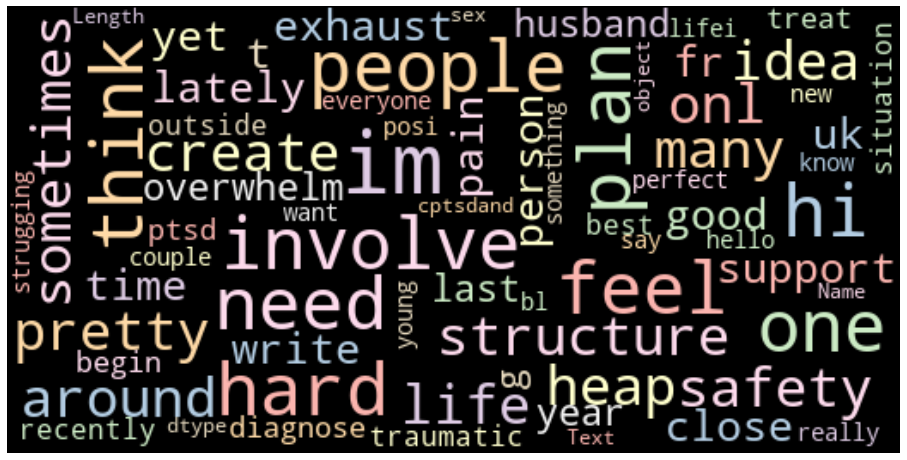

In [ ]:
sui_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(text1)
plt.figure(figsize=(16,10))
plt.imshow(sui_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

The WordCloud of the Suicide message:

In [ ]:
text2=str(df2.loc[df2.Label==1, 'Text'].astype(str))

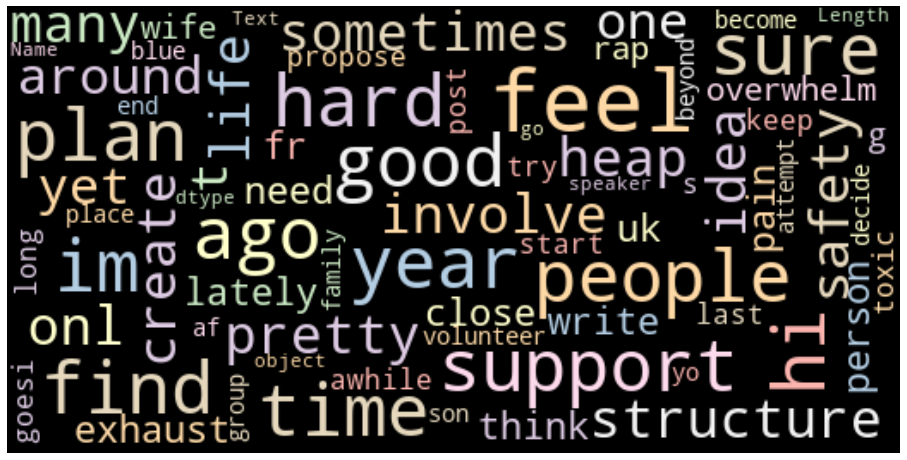

In [ ]:
sui_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(text2)
plt.figure(figsize=(16,10))
plt.imshow(sui_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

 Handling imbalance data

Text(0.5, 1.0, 'Distribution')

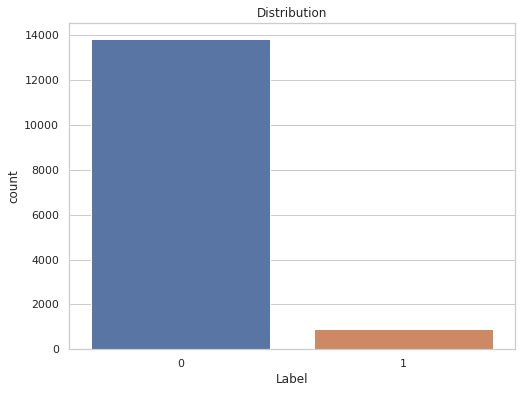

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df2.Label)
plt.title('Distribution')

In [ ]:
df2.loc[df2.Label==1, 'Text'].count()

891

In [ ]:
suicide=df2.loc[df2.Label==1]

In [ ]:
df2=df2.loc[df2.Label==0]

Text(0.5, 1.0, 'Distribution')

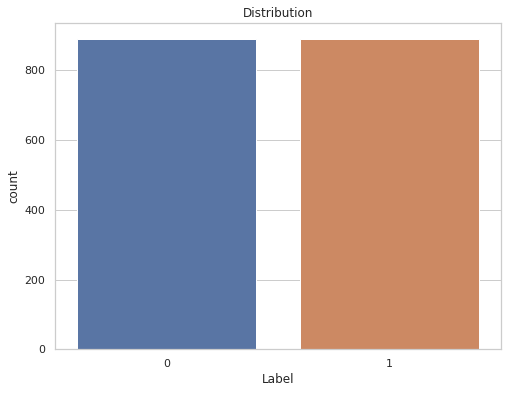

In [ ]:
# downsample the DF
df3 = df2.sample(n = 891, random_state = 0)
df3 = df3.append(suicide)


plt.figure(figsize=(8,6))
sns.countplot(df3.Label)
plt.title('Distribution')

**Text preprocessing**

In [ ]:

df3.columns

Index(['Unnamed: 0', 'Text', 'category', 'Topic', 'Label',
       'First person rate'],
      dtype='object')

In [ ]:
df3=df3[['Text',  'Topic', 'Label', 'First person rate']]

In [ ]:
df3.head()

,Text,Topic,Label,First person rate
12370,lose good friend today say lose push away,3,0,0.142857
4850,really need guidance accept new job start day ...,2,0,0.370787
14039,ok know start ive never anything like honestly...,2,0,0.378619
12118,hii join site hop connect others deal depressi...,3,0,0.376673
14417,world change th may daughter tell sexually abu...,3,0,0.261364


**Train test split**

\After that we do a train test split to divide the data into 80% train data and 20% test data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df3['Text'], df3['Label'], test_size=0.3, random_state=0)

**Tokenization**

We need to convert the text message data into numerical representation, so the model will understand it.

In [ ]:
# Defining pre-processing parameters
max_len = 200 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 200

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

7822

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df3[[ 'Text',  'Topic',  'First person rate']],df3['Label'], test_size=0.3, random_state=0)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC



In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


# Categorical pipeline
categorical_preprocessing = Pipeline(
[
    ('Imputation', SimpleImputer(strategy='constant')),
    ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore')),
]
)

# Numeric pipeline
numeric_preprocessing = Pipeline(
[
     ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
     ('Scaling', StandardScaler())
]
)

text_preprocessing = Pipeline(
[
     ('Text',TfidfVectorizer())       
]
)

# Creating preprocessing pipeline
preprocessing = make_column_transformer(
     (numeric_preprocessing, ['First person rate']),
     (categorical_preprocessing, ['Topic']),
     (text_preprocessing, 'Text'),
)

# Final pipeline
pipeline = Pipeline(
[('Preprocessing', preprocessing)]
)

x_train_ = pipeline.fit_transform(x_train)
x_test_ = preprocessing.transform(x_test)


In [ ]:
## you can just use preprocessor by itself

clf_s= SVC().fit(x_train_, y_train)
clf_s.score(x_test_, y_test)

0.7158878504672898

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0).fit(x_train_, y_train)
clf_lr.score(x_test_, y_test)

0.7570093457943925

Naive Bayes

In [ ]:
x_test_dense=x_test_.toarray()
x_train_dense=x_train_.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train_dense, y_train).predict(x_test_dense)
print("Number of mislabeled points out of a total %d points : %d"     
      % (x_test_dense.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 535 points : 199


In [ ]:
from sklearn.naive_bayes import CategoricalNB

In [ ]:
clf = CategoricalNB()

In [ ]:
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
x_train_dense = scaler.fit_transform(x_train_dense)
x_test_dense = scaler.transform(x_test_dense)

In [ ]:
clf.fit(x_train_dense, y_train)
clf.score(x_train_dense, y_train)

0.9823576583801122

ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [ ]:
clf3 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf3.fit(x_train_dense, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [ ]:
clf3.score(x_train_dense, y_train)

0.958299919807538

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}

base_estimator = RandomForestClassifier(random_state=0)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2, resource='n_estimators',
                          max_resources=30).fit(x_train_dense, y_train)
sh.best_estimator_


RandomForestClassifier(max_depth=10, n_estimators=24, random_state=0)

In [ ]:
RandomForestClassifier(max_depth=5, n_estimators=24, random_state=0)

RandomForestClassifier(max_depth=5, n_estimators=24, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rfc = RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=24, random_state=0)
rfc.fit(x_train_dense, y_train)
rfc.score(x_train_dense, y_train)

0.8219727345629511

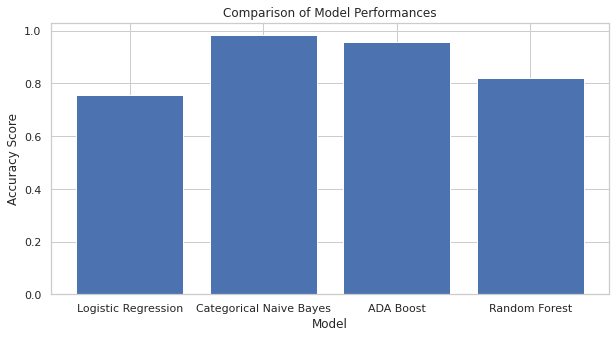

In [ ]:
import matplotlib.pyplot as plt

# Define the names of your models
models = ['Logistic Regression', 'Categorical Naive Bayes', 'ADA Boost', 'Random Forest']

# Define the performance of your models (for example, using accuracy scores)
scores = [clf_lr.score(x_test_, y_test), clf.score(x_train_dense, y_train), clf3.score(x_train_dense, y_train), rfc.score(x_train_dense, y_train)]

# creating the figure 
plt.figure(figsize=(10,5))  # width, height in inches

# Create the bar chart
plt.bar(models, scores)

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Performances')

# Show the chart
plt.show()
